In [7]:
batch_size = 128
#batch_size = 64 or 32 
epochs = 15
IMG_HEIGHT = 200
IMG_WIDTH = 200

# normalization and rescale
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our test data

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


<b>Visualize training images</b>

Visualize the training images by extracting a batch of images from the training generator—which is 32 images in this example—then plot five of them with `matplotlib`.

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

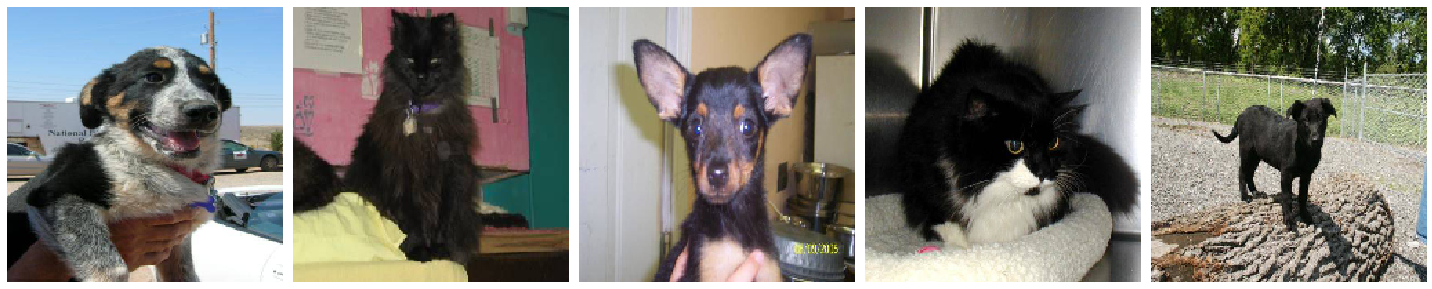

In [9]:
sample_training_images, _ = next(train_data_gen)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:5])

## Building the CNN

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a `relu` activation function.

In [8]:
# Initialize the CNN

# Dense
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='softmax')
])

# last layer: Softmax

# steps_per_epoch höher

# Dense output layer = fully connected = output

# Compiling the CNN
#model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
#
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

# View all the layers of the network using the model's `summary` method:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0

<b>Train the model</b>

Use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

In [9]:


# Model.fit()...
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=20,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=20
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 20 steps, validate for 20 steps
Epoch 1/15
20/20 [==============================] - 71s 4s/step - loss: 0.8164 - accuracy: 0.4969 - val_loss: 0.8156 - val_accuracy: 0.4977
Epoch 2/15
20/20 [==============================] - 65s 3s/step - loss: 0.8282 - accuracy: 0.4818 - val_loss: 0.8156 - val_accuracy: 0.4977
Epoch 3/15
20/20 [==============================] - 67s 3s/step - loss: 0.8105 - accuracy: 0.5027 - val_loss: 0.8156 - val_accuracy: 0.4977
Epoch 4/15
20/20 [==============================] - 66s 3s/step - loss: 0.7992 - accuracy: 0.5141 - val_loss: 0.8156 - val_accuracy: 0.4977
Epoch 5/15
20/20 [==============================] - 65s 3s/step - loss: 0.8273 - accuracy: 0.4859 - val_loss: 0.8156 - val_accuracy: 0.4977
Epoch 6/15
20/20 [==============================] - 68s 3s/step - loss: 0.7972 - accuracy: 0.5160 - val_loss: 0.8156 - val_accuracy:

<b>Visualize and evaluate training results</b>

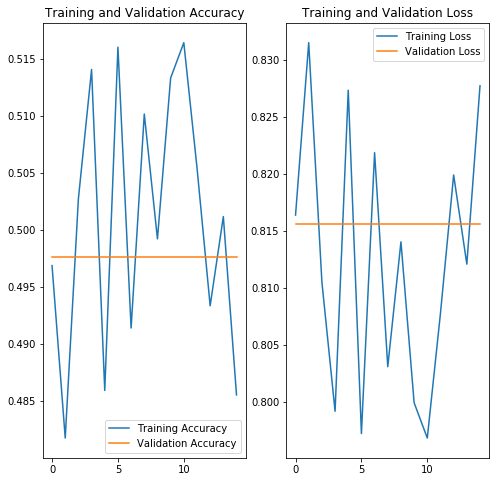


# Evaluate
  ...
    to  
  ['...']
50/50 [==============================] - 58s 1s/step - loss: 0.8165 - accuracy: 0.4955
[0.8164926552772522, 0.49547833]


In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print('\n# Evaluate')
result = model.evaluate(test_data_gen)
print(result)

=> After 15 epochs the model has scored 78,45% accuracy on training set and 76,33% accuracy on the validation set. This is a clear indication that our model has not overfitted. Our model will perform really good in the training set and it will also same for the unseen data.

=> To fix overfitting: add regularization to avoid over-complexing the model or add more data to the training set to make the model more generalized for unseen data (25k data should be okay, so skip this..., e.g. horizontal flip of the image, rotation etc.)

=> If we have < 2500 images, we should do this...

# TBD (Optimization, Verbesserungen, Dropout Reg., kernel-size/filter höher, mehr epochs, mehr dense layer etc.)

# Make predictions

Note: the subdirectories of images, one for each class, are loaded by the flow_from_directory() function in alphabetical order and assigned an integer for each class. The subdirectory “cat” comes before “dog“, therefore the class labels are assigned the integers: cat=0, dog=1. This can be changed via the “classes” argument in calling flow_from_directory() when training the model.

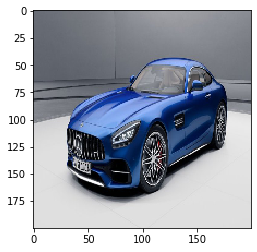

tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


{'cats': 0, 'dogs': 1}

In [14]:
sample = 'dataset/dataset_dogs_vs_cats/test/dogs/dog.9999.jpg'
sample = 'dataset/dataset_dogs_vs_cats/test/cats/cat.997.jpg'
sample_folder = 'dataset/samples/'
filename = "auto-2.jpg"

sample = sample_folder + filename

# load the image
test_img = load_img(sample, target_size=(200, 200))

# Show sample
plt.imshow(test_img)
plt.show()

# convert to array
test_img = img_to_array(test_img)

# reshape into a single sample with 3 channels
test_img = test_img.reshape(200, 200, 3)

# resize
#test_img = np.array(test_img).astype('float32')/255
test_img = test_img.astype('float32')/255

test_img = np.expand_dims(test_img, axis=0)

# Predict
result = model(test_img)

#.predict(test_img)

# > 0 = dog; < 0 = cat (-x...)


print(result)

train_data_gen.class_indices



# Conclusion

Bla bla bla

Herausforderungen:
* Gescheite datasets finden...
* https://datascience.stackexchange.com/questions/31167/how-to-predict-an-image-using-saved-model

# Next: CNN to predict persons/humans, cars, dogs and cats